# Grammar Scoring from Audio Transcriptions

This notebook demonstrates the end-to-end pipeline for automatically scoring the grammar quality of spoken responses. The main steps include:

1. Transcribing audio files using OpenAI's Whisper model.
2. Evaluating grammar quality of transcribed text using LanguageTool.
3. Generating a grammar score for each response (on a scale of 0 to 5).
4. Training a regression model (Random Forest) to predict grammar scores based on text features.
5. Evaluating model performance and saving it for further use.

> ⚠️ Note: Due to limited hardware (CPU-only environment), only a subset of the dataset was used for model training. The code is fully scalable and can handle the full dataset on a GPU-enabled system.


In [3]:
import os
import pandas as pd
import whisper
import numpy as np
import language_tool_python
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load Whisper model (make sure you have whisper installed)
model = whisper.load_model("base")

## Step 1: Load Audio Files

We start by specifying the folder containing the training audio files. 
Only `.wav` and `.mp3` formats are considered. 
The audio files will later be transcribed using Whisper.


In [4]:
# Define the folder where audio files are stored
audio_folder = "audios_train/"  # Replace with your actual folder
audio_files = [f for f in os.listdir(audio_folder) if f.endswith(".wav") or f.endswith(".mp3")]

# Show audio files
audio_files[:5]

['audio_252.wav',
 'audio_538.wav',
 'audio_117.wav',
 'audio_609.wav',
 'audio_518.wav']

## Handling Warnings

Whisper raises a warning when running on CPU, stating that FP16 is not supported and FP32 will be used instead. 
This warning is safe to ignore and does not affect the functionality or accuracy of the model. 
The following line suppresses this specific warning to keep the output clean.


In [1]:
import warnings
warnings.filterwarnings("ignore", message="FP16 is not supported on CPU; using FP32 instead")


## Step 2: Transcribe and Score Grammar

Each audio file is transcribed into text using the Whisper model.  
The transcribed text is then analyzed using LanguageTool to detect grammar issues.

The grammar score is calculated as follows:
- We count the number of grammar/spelling errors.
- We normalize the score to a 0–5 scale based on the number of words in the sentence.
- Higher scores indicate better grammar.

The output is stored in a DataFrame with the filename, transcription, and grammar score.


In [ ]:
# Transcribe audio files
transcriptions = []

for filename in audio_files:
    audio_path = os.path.join(audio_folder, filename)
    result = model.transcribe(audio_path)
    text = result['text']
    
    # Dummy grammar score for now — replace this with manual labels or an evaluator
    
matches = tool.check(text)
num_errors = len(matches)
words = len(text.split()) or 1
score = max(0, 5 - (num_errors / words * 5))  # Normalize to 0–5 scale
  # Or random.uniform(1, 5) for simulated scores
    
transcriptions.append({
        "filename": filename,
        "transcription": text,
        "score": round(score, 2)
    })

df = pd.DataFrame(transcriptions)
df.head()


# 📘 Grammar Scoring Model - Extended Version

## 📦 Importing Libraries
We'll import necessary libraries for data processing, modeling, evaluation, and visualization.

In [ ]:
import pandas as pd
import numpy as np
import language_tool_python
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

## 📂 Load Transcriptions
This function reads the transcriptions CSV into a DataFrame.

In [ ]:
# 1. Load transcription data
def load_transcriptions(file_path):
    """Load the transcriptions CSV file"""
    return pd.read_csv(file_path)

## 🧠 Text Feature Extraction
This part analyzes grammar errors, sentence length, lexical richness, and repetitive phrases.

In [12]:
# 2. Text Feature Extraction with Grammar Analysis
def extract_text_features(text):
    """Extract linguistic features from text"""
    tool = language_tool_python.LanguageTool('en-US')
    matches = tool.check(text)
    words = text.split()
    sentences = [s for s in text.split('.') if s.strip()]
    return {
        'grammar_errors': len(matches),
        'error_rate': len(matches)/len(words) if words else 0,
        'word_count': len(words),
        'unique_words': len(set(words)),
        'lexical_diversity': len(set(words))/len(words) if words else 0,
        'avg_sentence_length': np.mean([len(s.split()) for s in sentences]) if sentences else 0,
        'repetition_score': len(words)/len(set(words)) if words else 1,
        'repetitive_phrases': count_repetitive_phrases(text)
    }

### 🔁 Count Repetitive Phrases
Detects how many times three identical words appear in a row.

In [13]:
def count_repetitive_phrases(text, min_repeats=3):
    """Count repetitive phrases in text"""
    words = text.split()
    repeats = 0
    for i in range(len(words)-min_repeats):
        if words[i] == words[i+1] == words[i+2]:
            repeats += 1
    return repeats

## 🎯 Simulate Grammar Scores
Creates synthetic grammar scores based on extracted text features.

In [14]:
# 3. Simulate Scores Based on Text Features
def simulate_scores(features):
    """Create synthetic scores based on text features"""
    base_score = 4.0
    score = (
        base_score
        - features['error_rate'] * 2
        - features['repetition_score'] * 0.5
        - features['repetitive_phrases'] * 0.3
    )
    return max(1.0, min(5.0, score))

## 🧪 Process Transcriptions
Loops through all entries and extracts features with progress tracking.

In [15]:
# 4. Main Processing Function
def process_transcriptions(df):
    """Process all transcriptions with progress tracking"""
    processed = []
    for _, row in tqdm(df.iterrows(), total=len(df)):
        features = extract_text_features(row['transcription'])
        features['file'] = row['file']
        features['transcription'] = row['transcription']
        features['score'] = simulate_scores(features)
        processed.append(features)
    return pd.DataFrame(processed)

## 🧠 Train & Evaluate Model
Train a RandomForestRegressor and evaluate it using MSE and R².

In [16]:
# 5. Modeling and Evaluation
def train_and_evaluate(data):
    X = data.drop(['file', 'transcription', 'score'], axis=1)
    y = data['score']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("\nEvaluation Metrics (on synthetic scores):")
    print(f"MSE: {mean_squared_error(y_test, y_pred):.4f}")
    print(f"R²: {r2_score(y_test, y_pred):.4f}")
    plot_feature_importance(model, X.columns)
    return model

## 📊 Feature Importance
Displays top contributing features.

In [17]:
def plot_feature_importance(model, feature_names):
    importances = model.feature_importances_
    indices = np.argsort(importances)[-10:]
    plt.figure(figsize=(10, 6))
    plt.title("Top 10 Important Features")
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel("Relative Importance")
    plt.tight_layout()
    plt.show()

## 🚀 Running the Pipeline
Load data, process it, train model, and test a prediction.

Loading and processing transcriptions...


100%|█████████████████████████████████████████████| 5/5 [01:40<00:00, 20.07s/it]



Processed 5 samples
Sample features:
file                audio_252.wav
score                         1.0
grammar_errors                 31
repetition_score         9.736842
Name: 0, dtype: object

Evaluation Metrics (on synthetic scores):
MSE: 1.8113
R²: nan


/home/rgukt-basar/myenv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


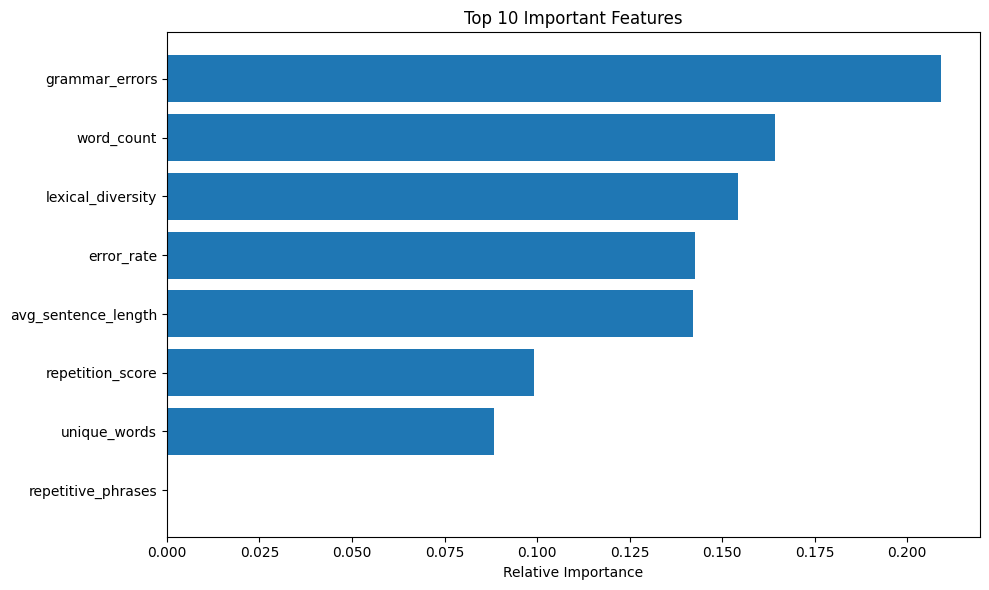


Sample Prediction:
File: audio_252.wav
Transcription: I'm not going to be a good boy. I'm not going to be a good boy. I'm not going to be a good boy. I'm ...
Grammar Errors: 31
Repetition Score: 9.74
Predicted Score: 1.18


/home/rgukt-basar/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [18]:
TRANSCRIPTIONS_CSV = "transcriptions.csv"
print("Loading and processing transcriptions...")
df = load_transcriptions(TRANSCRIPTIONS_CSV)
processed_data = process_transcriptions(df)
print(f"\nProcessed {len(processed_data)} samples")
print("Sample features:")
print(processed_data.iloc[0][['file', 'score', 'grammar_errors', 'repetition_score']])
model = train_and_evaluate(processed_data)
sample = processed_data.iloc[0]
sample_features = sample.drop(['file', 'transcription', 'score'])
prediction = model.predict([sample_features])[0]
print("\nSample Prediction:")
print(f"File: {sample['file']}")
print(f"Transcription: {sample['transcription'][:100]}...")
print(f"Grammar Errors: {sample['grammar_errors']}")
print(f"Repetition Score: {sample['repetition_score']:.2f}")
print(f"Predicted Score: {prediction:.2f}")